<a href="https://colab.research.google.com/github/debashisdotchatterjee/Optimal-Transport-Based-Spatio-Temporal-Land-Allocation/blob/main/Code_for_Optimal_Transport_Based_Spatio_Temporal_Land_Allocation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[install] pandas-datareader>=0.10.0
[install] scikit-learn>=1.2.0
[install] POT>=0.9.3
[info] Run timestamp: 20260215_041513
[info] Saving to: outputs/
[info] Downloading WDI series ...
[saved] outputs/tables/wdi_land_raw.csv

[preview] Raw head:
country_name iso3c  year  agri_land_pct  forest_pct  arable_pct
   Argentina   ARG  2000      46.958187   12.196486   10.099792
   Argentina   ARG  2001      46.993266   12.080871   10.138525
   Argentina   ARG  2002      47.031268   11.965257   10.180912
   Argentina   ARG  2003      47.174981   11.849643   10.899371
   Argentina   ARG  2004      47.318695   11.734029   11.617830
   Argentina   ARG  2005      47.473737   11.618415   12.347617
   Argentina   ARG  2006      47.553395   11.502801   13.002021
   Argentina   ARG  2007      47.491093   11.387187   13.514465
   Argentina   ARG  2008      46.423563   11.271573   13.021679
   Argentina   ARG  2009      45.430209   11.155958   12.603072
   Argentina   ARG  2010      46.138912   11.0403

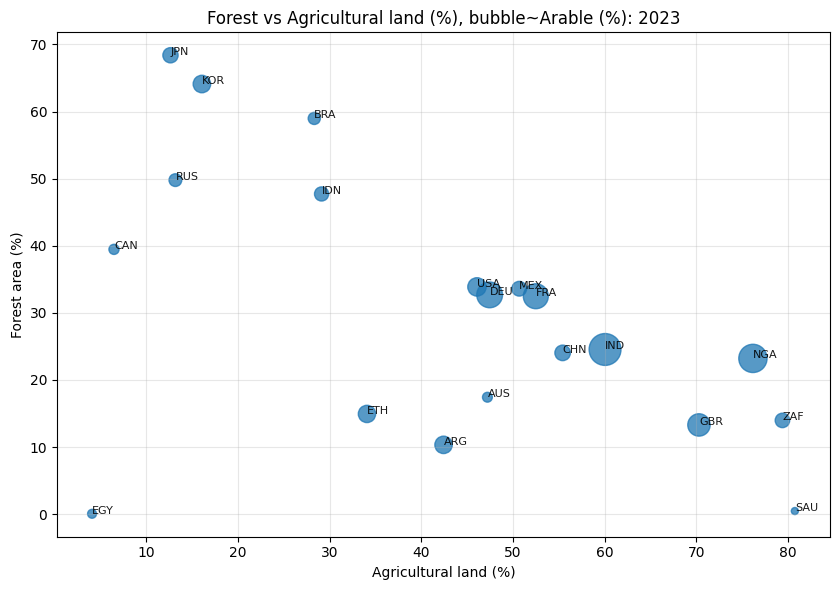

[saved] outputs/tables/corr_snapshot_2023.csv
[saved] outputs/figures/corr_heatmap_2023.png


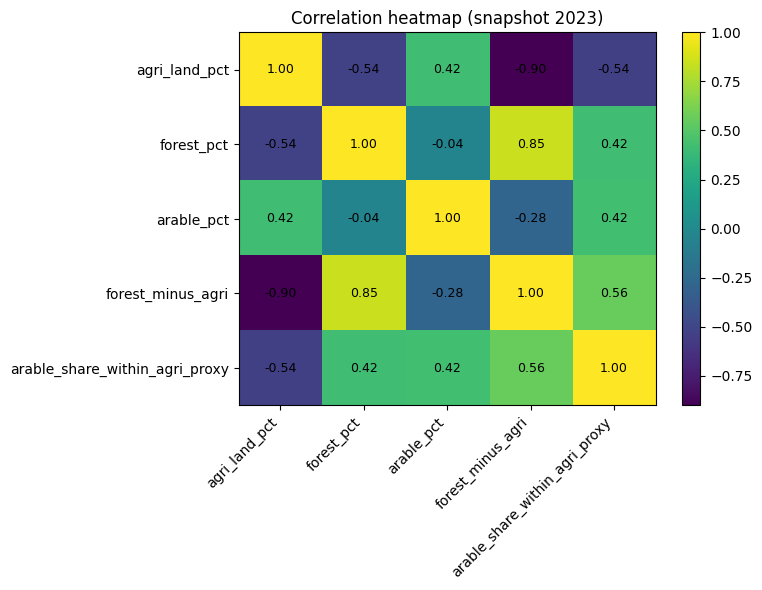


[saved] outputs/tables/pairwise_ot_cost_2023.csv

[table] Pairwise OT-cost matrix (top-left 8x8):
        JPN     KOR     BRA     RUS     IDN     CAN     USA     MEX
JPN  0.0000  0.1730  0.2790  0.0851  0.3896  0.1191  0.8343  0.7860
KOR  0.1730  0.0000  0.1790  0.1177  0.2896  0.2921  0.6614  0.6860
BRA  0.2790  0.1790  0.0000  0.1940  0.1868  0.3300  0.6544  0.5831
RUS  0.0851  0.1177  0.1940  0.0000  0.3114  0.1744  0.7790  0.7077
IDN  0.3896  0.2896  0.1868  0.3114  0.0000  0.4858  0.4676  0.3964
CAN  0.1191  0.2921  0.3300  0.1744  0.4858  0.0000  0.9534  0.8821
USA  0.8343  0.6614  0.6544  0.7790  0.4676  0.9534  0.0000  0.0714
MEX  0.7860  0.6860  0.5831  0.7077  0.3964  0.8821  0.0714  0.0000
[saved] outputs/tables/target_composition_2023.csv

[target] Sustainable target composition (median-normalized):
p_agri      0.5395
p_forest    0.3296
p_arable    0.1309

[saved] outputs/tables/restoration_plan_ot_2023.csv

[table] Restoration plan (closest to target by OT cost):
group_ke

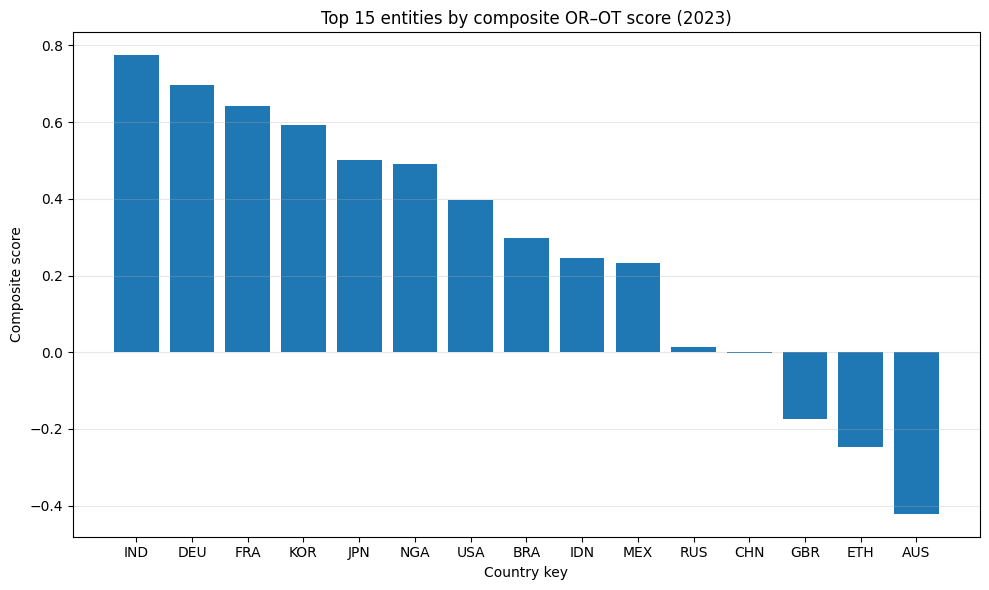


[saved] outputs/tables/pca_snapshot_2023.csv
[saved] outputs/figures/pca_snapshot_2023.png


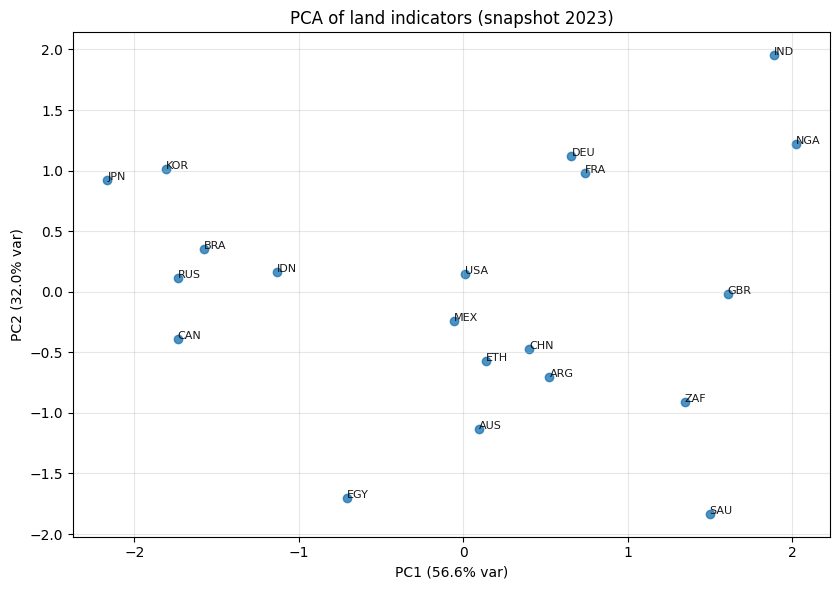

[saved] outputs/figures/timeseries_IND.png


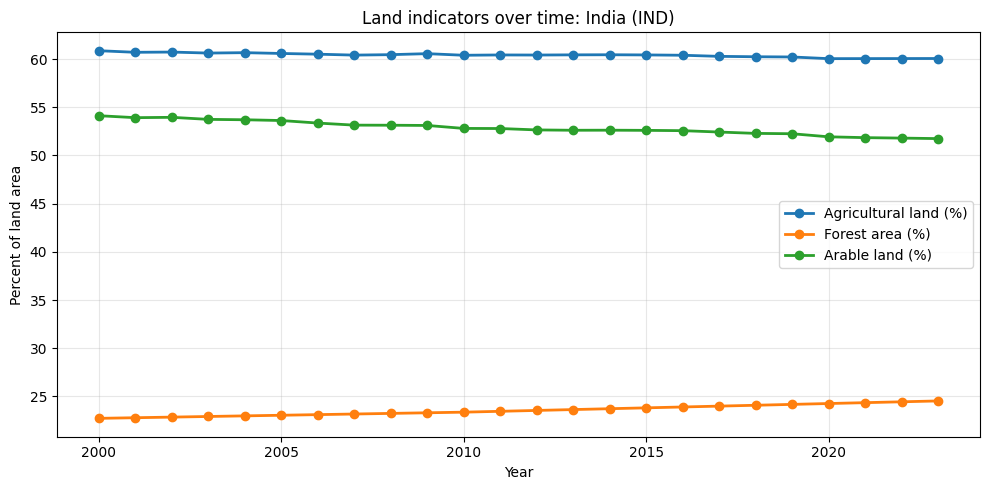

[saved] outputs/figures/stacked_comp_IND.png


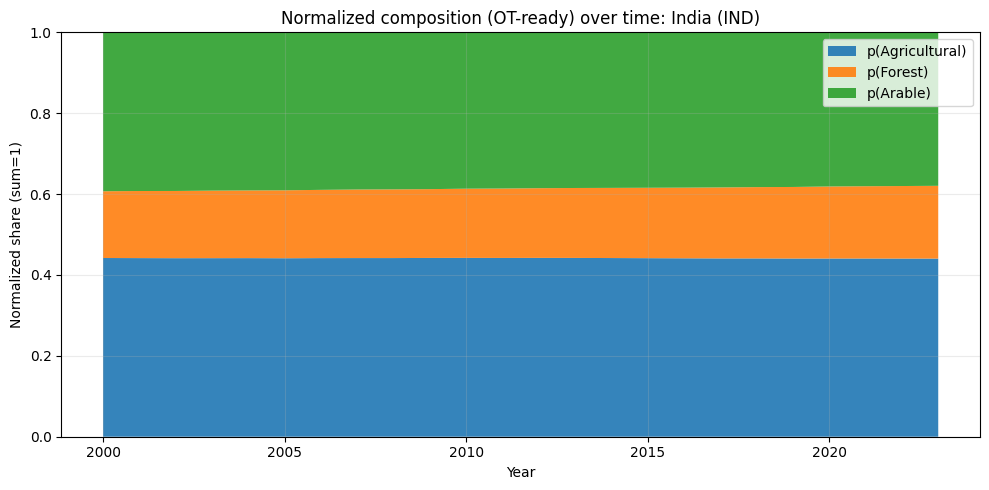

[saved] outputs/figures/timeseries_BRA.png


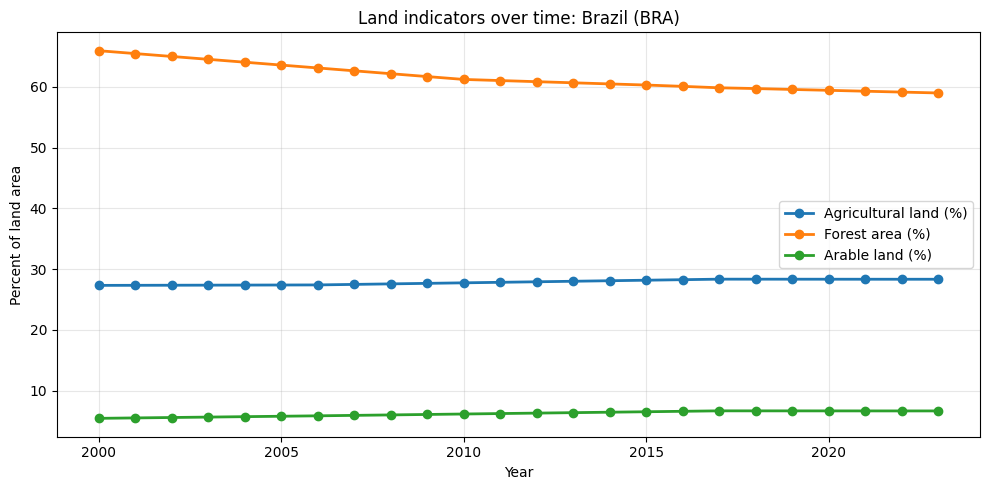

[saved] outputs/figures/stacked_comp_BRA.png


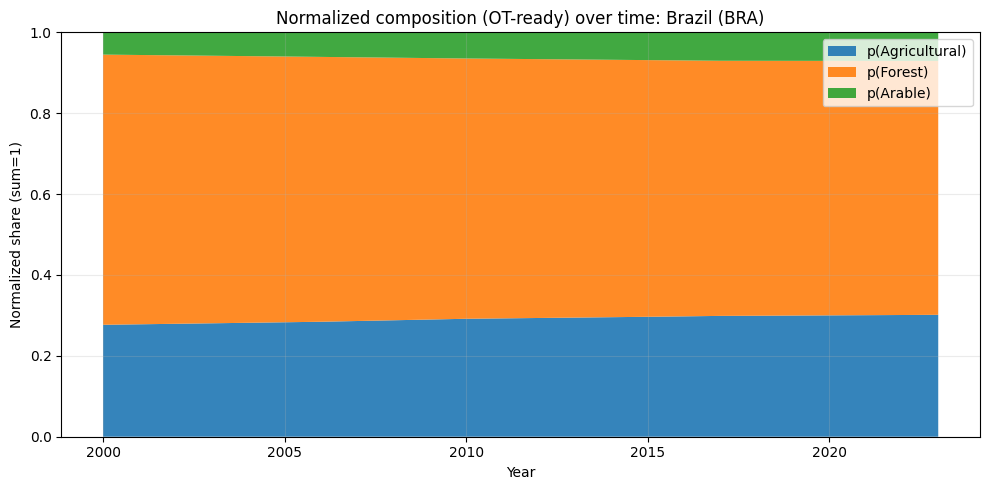

[saved] outputs/figures/timeseries_ZAF.png


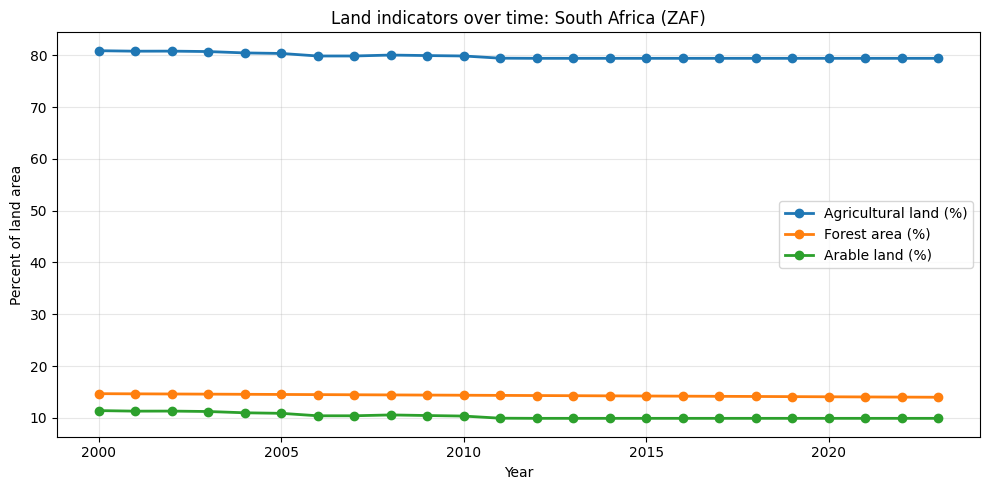

[saved] outputs/figures/stacked_comp_ZAF.png


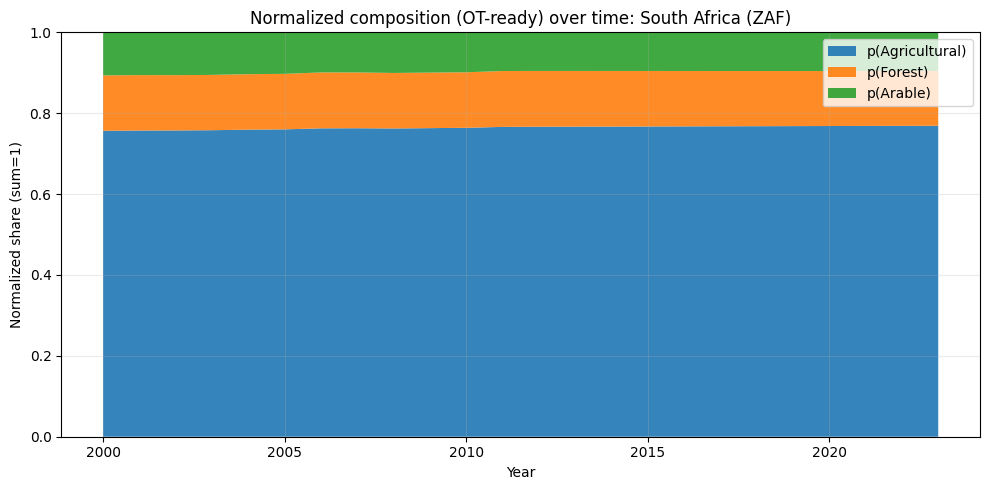

[saved] outputs/figures/timeseries_USA.png


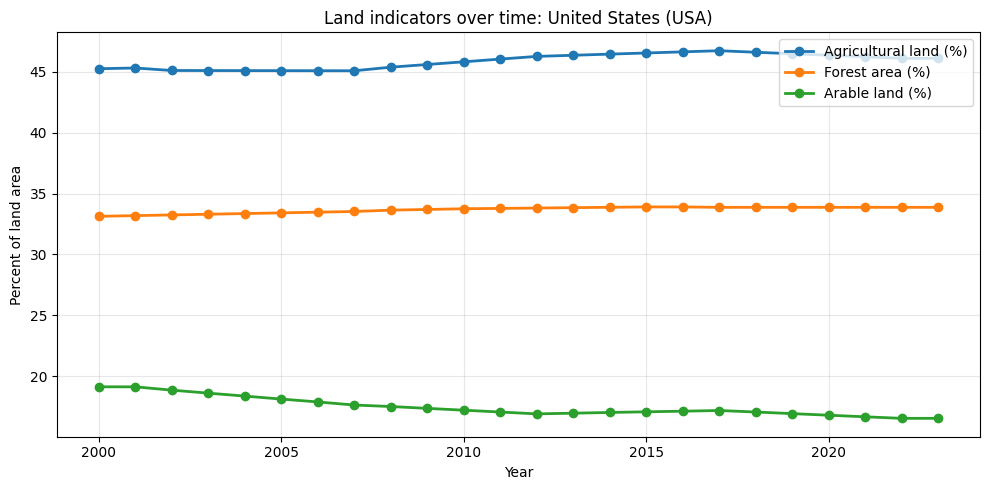

[saved] outputs/figures/stacked_comp_USA.png


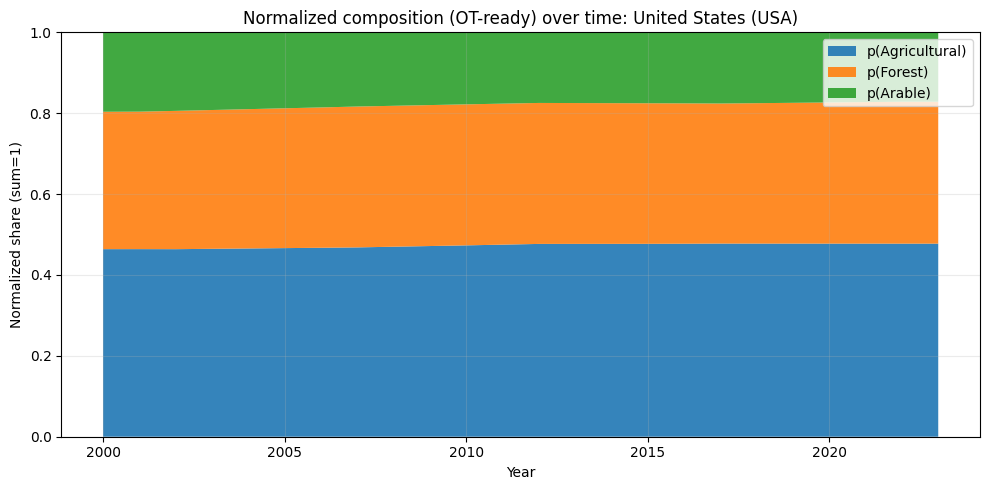

[saved] outputs/figures/frontier_arable_vs_forest_bubble_otcost_2023.png


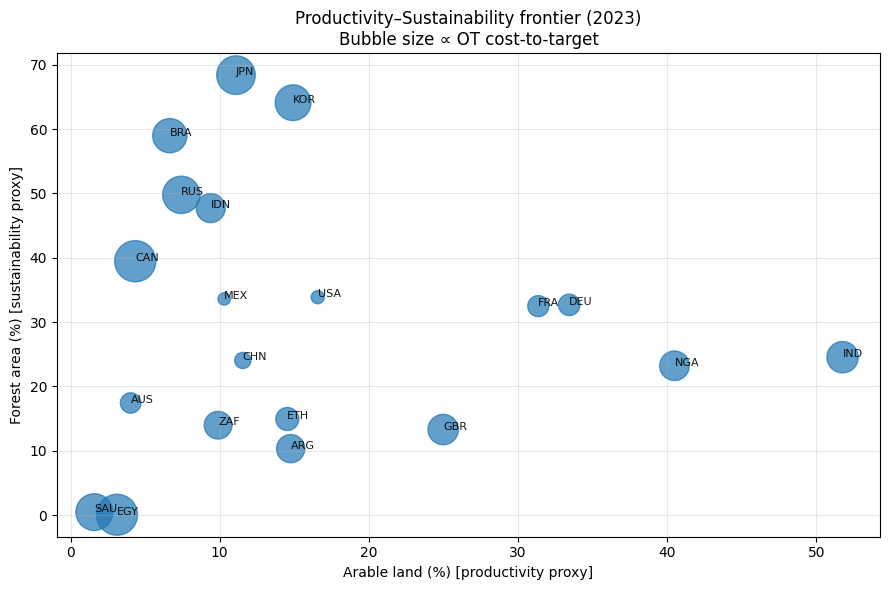


[saved] outputs/tables/final_report_table_2023.csv

===== FINAL REPORT (top 20, copy-ready) =====
group_key       country_name iso3c  year  agri_land_pct  forest_pct  arable_pct  ot_cost_to_target  shift_agri  shift_forest  shift_arable  composite_score
      IND              India   IND  2023        60.0604     24.5390     51.7521             0.5480      0.0990        0.1497       -0.2486           0.7742
      DEU            Germany   DEU  2023        47.4659     32.6789     33.4287             0.2472      0.1215        0.0419       -0.1634           0.6971
      FRA             France   FRA  2023        52.5044     32.4765     31.3559             0.2396      0.0881        0.0505       -0.1386           0.6429
      KOR        Korea, Rep.   KOR  2023        16.0656     64.1086     14.9180             0.7150      0.3705       -0.3445       -0.0260           0.5928
      JPN              Japan   JPN  2023        12.6368     68.3958     11.0925             0.8361      0.4023       -0.4

In [3]:
# ============================================================
# Google Colab-ready (FULLY FIXED) Python pipeline
# OR + Optimal Transport (OT) for Land Allocation / Restoration
# Data: World Bank WDI land indicators via pandas-datareader (wb)
#
# FIXES the error you saw:
#   ValueError: ndarray is not C-contiguous
#   -> POT's network simplex EMD implementation needs C-contiguous float64 arrays.
#   -> This code forces np.ascontiguousarray(..., dtype=np.float64) for a, b, M.
#
# Outputs (auto-saved):
#   outputs/tables/*.csv
#   outputs/figures/*.png
#   outputs/outputs.zip
#
# Also:
#   - prints key tables in console (copy-ready)
#   - shows all plots via plt.show()
# ============================================================

# -----------------------------
# 0) Setup
# -----------------------------
import os, sys, zipfile, warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.width", 220)
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 80)

def ensure_pip(pkgs):
    import importlib, subprocess
    for p in pkgs:
        name = p.split("==")[0].split(">=")[0].split("[")[0]
        try:
            importlib.import_module(name)
        except Exception:
            print(f"[install] {p}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])

ensure_pip([
    "pandas-datareader>=0.10.0",
    "pycountry>=22.3.5",
    "scikit-learn>=1.2.0",
    "POT>=0.9.3"
])

from pandas_datareader import wb
import pycountry
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import ot  # POT

# Output dirs
OUTDIR = "outputs"
FIGDIR = os.path.join(OUTDIR, "figures")
TABDIR = os.path.join(OUTDIR, "tables")
os.makedirs(FIGDIR, exist_ok=True)
os.makedirs(TABDIR, exist_ok=True)

RUNSTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"[info] Run timestamp: {RUNSTAMP}")
print(f"[info] Saving to: {OUTDIR}/")

# -----------------------------
# 1) Data pull (World Bank WDI)
# -----------------------------
INDICATORS = {
    "AG.LND.AGRI.ZS": "agri_land_pct",   # Agricultural land (% of land area)
    "AG.LND.FRST.ZS": "forest_pct",      # Forest area (% of land area)
    "AG.LND.ARBL.ZS": "arable_pct",      # Arable land (% of land area)
}

COUNTRIES = [
    "IND", "CHN", "USA", "BRA", "ZAF", "AUS", "CAN", "RUS",
    "IDN", "MEX", "NGA", "EGY", "ETH", "FRA", "DEU", "GBR",
    "JPN", "KOR", "ARG", "SAU"
]

START_YEAR = 2000
END_YEAR = 2023

print("[info] Downloading WDI series ...")
raw = wb.download(
    indicator=list(INDICATORS.keys()),
    country=COUNTRIES,
    start=START_YEAR,
    end=END_YEAR
).reset_index()

raw = raw.rename(columns=INDICATORS)
raw = raw.rename(columns={"country": "country_name", "year": "year"})
raw["year"] = pd.to_numeric(raw["year"], errors="coerce").astype(int)

# ISO3 mapping (best-effort + manual for WB names)
def name_to_iso3(name):
    try:
        c = pycountry.countries.lookup(name)
        return c.alpha_3
    except Exception:
        return None

raw["iso3c"] = raw["country_name"].apply(name_to_iso3)
MANUAL_ISO3 = {
    "Egypt, Arab Rep.": "EGY",
    "Korea, Rep.": "KOR",
    "Russian Federation": "RUS",
    "United Kingdom": "GBR",
    "United States": "USA",
    "Saudi Arabia": "SAU",
    "South Africa": "ZAF",
}
raw["iso3c"] = raw.apply(lambda r: MANUAL_ISO3.get(r["country_name"], r["iso3c"]), axis=1)

for col in INDICATORS.values():
    raw[col] = pd.to_numeric(raw[col], errors="coerce")

raw_path = os.path.join(TABDIR, "wdi_land_raw.csv")
raw.to_csv(raw_path, index=False)
print(f"[saved] {raw_path}")

print("\n[preview] Raw head:")
print(raw[["country_name","iso3c","year"] + list(INDICATORS.values())].head(12).to_string(index=False))

# -----------------------------
# 2) Coverage + interpolation (index-safe)
# -----------------------------
df = raw.copy()
df["group_key"] = df["iso3c"].fillna(df["country_name"])

coverage = (
    df.groupby("group_key")[list(INDICATORS.values())]
      .apply(lambda g: g.notna().mean())
      .reset_index()
)
coverage.columns = ["group_key"] + [f"coverage_{c}" for c in INDICATORS.values()]

meta = (
    df.groupby("group_key")[["country_name","iso3c"]]
      .agg(lambda s: s.dropna().iloc[0] if s.dropna().shape[0] else np.nan)
      .reset_index()
)

coverage = coverage.merge(meta, on="group_key", how="left")
coverage = coverage[["group_key","country_name","iso3c"] + [c for c in coverage.columns if c.startswith("coverage_")]]

cov_path = os.path.join(TABDIR, "coverage_by_country.csv")
coverage.to_csv(cov_path, index=False)
print(f"\n[saved] {cov_path}")

print("\n[table] Coverage by country (fraction non-missing):")
print(coverage.sort_values(by="coverage_agri_land_pct", ascending=False).to_string(index=False))

df = df.sort_values(["group_key","year"]).reset_index(drop=True)

# interpolate per group using transform (keeps same index)
for col in INDICATORS.values():
    df[col] = df.groupby("group_key")[col].transform(lambda s: s.interpolate(limit_direction="both"))

df = df.dropna(subset=list(INDICATORS.values())).reset_index(drop=True)

# -----------------------------
# 3) Feature engineering
# -----------------------------
eps = 1e-12
comp_cols = ["agri_land_pct","forest_pct","arable_pct"]

df["sum_pct"] = df[comp_cols].sum(axis=1) + eps
for c in comp_cols:
    df[f"p_{c}"] = df[c] / df["sum_pct"]

df["forest_minus_agri"] = df["forest_pct"] - df["agri_land_pct"]
df["arable_share_within_agri_proxy"] = df["arable_pct"] / (df["agri_land_pct"] + eps)

feat_path = os.path.join(TABDIR, "wdi_land_features.csv")
df.to_csv(feat_path, index=False)
print(f"\n[saved] {feat_path}")

latest_year = int(df["year"].max())
snap = df[df["year"] == latest_year].copy()

snap = snap[[
    "group_key","country_name","iso3c","year",
    *comp_cols,
    *(f"p_{c}" for c in comp_cols),
    "forest_minus_agri","arable_share_within_agri_proxy"
]].sort_values("forest_pct", ascending=False).reset_index(drop=True)

snap_path = os.path.join(TABDIR, f"snapshot_{latest_year}.csv")
snap.to_csv(snap_path, index=False)
print(f"[saved] {snap_path}")

print(f"\n[table] Snapshot ({latest_year}) head:")
print(snap.head(12).round(4).to_string(index=False))

# -----------------------------
# 4) Plot helpers
# -----------------------------
def savefig(name):
    path = os.path.join(FIGDIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=220, bbox_inches="tight")
    print(f"[saved] {path}")
    return path

def country_timeseries_plot(group_key):
    d = df[df["group_key"] == group_key].sort_values("year")
    if d.empty:
        return
    title_name = d["country_name"].iloc[0]
    plt.figure(figsize=(10, 5))
    plt.plot(d["year"], d["agri_land_pct"], marker="o", linewidth=2, label="Agricultural land (%)")
    plt.plot(d["year"], d["forest_pct"], marker="o", linewidth=2, label="Forest area (%)")
    plt.plot(d["year"], d["arable_pct"], marker="o", linewidth=2, label="Arable land (%)")
    plt.title(f"Land indicators over time: {title_name} ({group_key})")
    plt.xlabel("Year"); plt.ylabel("Percent of land area")
    plt.grid(True, alpha=0.3); plt.legend()
    savefig(f"timeseries_{group_key}.png")
    plt.show()

def stacked_composition_plot(group_key):
    d = df[df["group_key"] == group_key].sort_values("year")
    if d.empty:
        return
    title_name = d["country_name"].iloc[0]
    plt.figure(figsize=(10, 5))
    y1 = d["p_agri_land_pct"].values
    y2 = d["p_forest_pct"].values
    y3 = d["p_arable_pct"].values
    plt.stackplot(d["year"], y1, y2, y3,
                  labels=["p(Agricultural)", "p(Forest)", "p(Arable)"], alpha=0.9)
    plt.title(f"Normalized composition (OT-ready) over time: {title_name} ({group_key})")
    plt.xlabel("Year"); plt.ylabel("Normalized share (sum=1)")
    plt.ylim(0, 1); plt.grid(True, alpha=0.25); plt.legend(loc="upper right")
    savefig(f"stacked_comp_{group_key}.png")
    plt.show()

# -----------------------------
# 5) Global plots (snapshot)
# -----------------------------
plt.figure(figsize=(8.5, 6))
x = snap["agri_land_pct"].values
y = snap["forest_pct"].values
s = (snap["arable_pct"].values + 1.0) * 10.0
plt.scatter(x, y, s=s, alpha=0.75)
for _, r in snap.iterrows():
    tag = r["iso3c"] if pd.notna(r["iso3c"]) else str(r["country_name"])[:3]
    plt.text(r["agri_land_pct"], r["forest_pct"], tag, fontsize=8, alpha=0.9)
plt.title(f"Forest vs Agricultural land (%), bubble~Arable (%): {latest_year}")
plt.xlabel("Agricultural land (%)"); plt.ylabel("Forest area (%)")
plt.grid(True, alpha=0.3)
savefig(f"scatter_forest_vs_agri_{latest_year}.png")
plt.show()

corr = snap[comp_cols + ["forest_minus_agri","arable_share_within_agri_proxy"]].corr()
corr_path = os.path.join(TABDIR, f"corr_snapshot_{latest_year}.csv")
corr.to_csv(corr_path)
print(f"[saved] {corr_path}")

plt.figure(figsize=(7.8, 6))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title(f"Correlation heatmap (snapshot {latest_year})")
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center", fontsize=9)
plt.colorbar()
savefig(f"corr_heatmap_{latest_year}.png")
plt.show()

# -----------------------------
# 6) OT core (FIXED: enforce C-contiguous float64)
# -----------------------------
# Ground cost matrix over 3 categories
C = np.array([
    [0.0, 2.0, 1.0],
    [2.0, 0.0, 3.0],
    [1.0, 3.0, 0.0]
], dtype=np.float64)
C = np.ascontiguousarray(C)

# OT-ready compositions (FORCE contiguous float64)
P = snap[["p_agri_land_pct","p_forest_pct","p_arable_pct"]].to_numpy(dtype=np.float64, copy=True)
P = np.ascontiguousarray(P)

labels = snap["group_key"].astype(str).tolist()
n = len(labels)

def emd2_safe(a, b, M):
    """
    POT network simplex EMD requires:
      - a, b, M: float64
      - C-contiguous arrays
      - a,b sum to same mass (here 1.0)
    """
    a = np.ascontiguousarray(np.asarray(a, dtype=np.float64))
    b = np.ascontiguousarray(np.asarray(b, dtype=np.float64))
    M = np.ascontiguousarray(np.asarray(M, dtype=np.float64))
    # tiny renormalization for numerical safety
    a = a / (a.sum() + 1e-15)
    b = b / (b.sum() + 1e-15)
    return float(ot.emd2(a, b, M))

def emd_safe(a, b, M):
    a = np.ascontiguousarray(np.asarray(a, dtype=np.float64))
    b = np.ascontiguousarray(np.asarray(b, dtype=np.float64))
    M = np.ascontiguousarray(np.asarray(M, dtype=np.float64))
    a = a / (a.sum() + 1e-15)
    b = b / (b.sum() + 1e-15)
    G = ot.emd(a, b, M)
    return np.ascontiguousarray(G, dtype=np.float64)

# Pairwise OT cost matrix
D = np.zeros((n, n), dtype=np.float64)
for i in range(n):
    for j in range(i+1, n):
        D[i, j] = emd2_safe(P[i], P[j], C)
        D[j, i] = D[i, j]

D_df = pd.DataFrame(D, index=labels, columns=labels)
D_path = os.path.join(TABDIR, f"pairwise_ot_cost_{latest_year}.csv")
D_df.to_csv(D_path)
print(f"\n[saved] {D_path}")

print("\n[table] Pairwise OT-cost matrix (top-left 8x8):")
print(D_df.iloc[:8, :8].round(4).to_string())

# Target = median composition across countries (robust)
eps = 1e-12
target_raw = snap[comp_cols].median().to_numpy(dtype=np.float64)
target = target_raw / (target_raw.sum() + eps)
target = np.ascontiguousarray(target, dtype=np.float64)

target_series = pd.Series(target, index=["p_agri","p_forest","p_arable"], name="target")
target_path = os.path.join(TABDIR, f"target_composition_{latest_year}.csv")
target_series.to_csv(target_path)
print(f"[saved] {target_path}")

print("\n[target] Sustainable target composition (median-normalized):")
print(target_series.round(4).to_string())

# Transport plans to target
plans = []
gamma_blocks = []

for idx, gkey in enumerate(labels):
    p = P[idx]
    q = target
    gamma = emd_safe(p, q, C)
    cost = float(np.sum(gamma * C))
    shift = q - p

    row = snap.loc[idx]
    plans.append({
        "group_key": gkey,
        "country_name": row["country_name"],
        "iso3c": row["iso3c"],
        "ot_cost_to_target": cost,
        "p_agri": p[0], "p_forest": p[1], "p_arable": p[2],
        "q_agri": q[0], "q_forest": q[1], "q_arable": q[2],
        "shift_agri": shift[0], "shift_forest": shift[1], "shift_arable": shift[2],
    })

    gdf = pd.DataFrame(gamma,
                       index=["from_agri","from_forest","from_arable"],
                       columns=["to_agri","to_forest","to_arable"]).reset_index()
    gdf = gdf.rename(columns={"index":"from_category"})
    gdf.insert(0, "group_key", gkey)
    gamma_blocks.append(gdf)

plans_df = pd.DataFrame(plans).sort_values("ot_cost_to_target", ascending=True).reset_index(drop=True)
plan_path = os.path.join(TABDIR, f"restoration_plan_ot_{latest_year}.csv")
plans_df.to_csv(plan_path, index=False)
print(f"\n[saved] {plan_path}")

print("\n[table] Restoration plan (closest to target by OT cost):")
print(plans_df.head(12).round(4).to_string(index=False))

gamma_long = pd.concat(gamma_blocks, ignore_index=True)
gamma_path = os.path.join(TABDIR, f"ot_transport_plans_{latest_year}.csv")
gamma_long.to_csv(gamma_path, index=False)
print(f"[saved] {gamma_path}")

# -----------------------------
# 7) Multi-objective OR-style scoring
# -----------------------------
wP, wS, wC = 0.35, 0.45, 0.20

score_df = snap.merge(plans_df[["group_key","ot_cost_to_target"]], on="group_key", how="left")

def zscore(arr):
    arr = np.asarray(arr, dtype=np.float64)
    return (arr - np.nanmean(arr)) / (np.nanstd(arr) + 1e-12)

score_df["z_arable"] = zscore(score_df["arable_pct"])
score_df["z_forest"] = zscore(score_df["forest_pct"])
score_df["z_cost"]   = zscore(score_df["ot_cost_to_target"])

score_df["composite_score"] = wP*score_df["z_arable"] + wS*score_df["z_forest"] - wC*score_df["z_cost"]
score_df = score_df.sort_values("composite_score", ascending=False).reset_index(drop=True)

score_path = os.path.join(TABDIR, f"multiobjective_score_{latest_year}.csv")
score_df.to_csv(score_path, index=False)
print(f"\n[saved] {score_path}")

print("\n[table] Multi-objective ranking (top 15):")
print(score_df[["group_key","country_name","iso3c","arable_pct","forest_pct","ot_cost_to_target","composite_score"]].head(15).round(4).to_string(index=False))

plt.figure(figsize=(10, 6))
topk = min(15, len(score_df))
plt.bar(score_df["group_key"].head(topk).astype(str), score_df["composite_score"].head(topk))
plt.title(f"Top {topk} entities by composite OR–OT score ({latest_year})")
plt.xlabel("Country key"); plt.ylabel("Composite score")
plt.grid(True, axis="y", alpha=0.3)
savefig(f"bar_composite_score_top{topk}_{latest_year}.png")
plt.show()

# -----------------------------
# 8) PCA plot (snapshot)
# -----------------------------
X = snap[comp_cols].to_numpy(dtype=np.float64, copy=True)
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "group_key": snap["group_key"].astype(str).values,
    "country_name": snap["country_name"].values,
    "iso3c": snap["iso3c"].values,
    "PC1": Z[:,0], "PC2": Z[:,1],
    "agri_land_pct": snap["agri_land_pct"].values,
    "forest_pct": snap["forest_pct"].values,
    "arable_pct": snap["arable_pct"].values,
})
pca_path = os.path.join(TABDIR, f"pca_snapshot_{latest_year}.csv")
pca_df.to_csv(pca_path, index=False)
print(f"\n[saved] {pca_path}")

plt.figure(figsize=(8.5, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.8)
for _, r in pca_df.iterrows():
    tag = r["iso3c"] if pd.notna(r["iso3c"]) else str(r["group_key"])[:3]
    plt.text(r["PC1"], r["PC2"], tag, fontsize=8, alpha=0.9)
plt.title(f"PCA of land indicators (snapshot {latest_year})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True, alpha=0.3)
savefig(f"pca_snapshot_{latest_year}.png")
plt.show()

# -----------------------------
# 9) Time-series plots for selected countries
# -----------------------------
SHOW_KEYS = ["IND", "BRA", "ZAF", "USA"]
for gk in SHOW_KEYS:
    if gk not in set(df["group_key"].astype(str).unique()):
        print(f"[warn] Could not find series for {gk}")
        continue
    country_timeseries_plot(gk)
    stacked_composition_plot(gk)

# -----------------------------
# 10) Frontier plot: arable vs forest, bubble size ∝ OT cost
# -----------------------------
front = snap.merge(plans_df[["group_key","ot_cost_to_target"]], on="group_key", how="left")

plt.figure(figsize=(9, 6))
sizes = front["ot_cost_to_target"].to_numpy(dtype=np.float64)
sizes = (sizes - np.nanmin(sizes) + 1e-9)
sizes = (sizes / (np.nanmax(sizes) + 1e-12)) * 800 + 80
plt.scatter(front["arable_pct"], front["forest_pct"], s=sizes, alpha=0.7)

for _, r in front.iterrows():
    tag = r["iso3c"] if pd.notna(r["iso3c"]) else str(r["group_key"])[:3]
    plt.text(r["arable_pct"], r["forest_pct"], tag, fontsize=8, alpha=0.9)

plt.title(f"Productivity–Sustainability frontier ({latest_year})\nBubble size ∝ OT cost-to-target")
plt.xlabel("Arable land (%) [productivity proxy]")
plt.ylabel("Forest area (%) [sustainability proxy]")
plt.grid(True, alpha=0.3)
savefig(f"frontier_arable_vs_forest_bubble_otcost_{latest_year}.png")
plt.show()

# -----------------------------
# 11) Final copy-ready report table
# -----------------------------
report = score_df.merge(
    plans_df[["group_key","shift_agri","shift_forest","shift_arable"]],
    on="group_key", how="left"
)

report_cols = [
    "group_key","country_name","iso3c","year",
    "agri_land_pct","forest_pct","arable_pct",
    "ot_cost_to_target",
    "shift_agri","shift_forest","shift_arable",
    "composite_score"
]
report = report[report_cols].sort_values("composite_score", ascending=False).reset_index(drop=True)

report_path = os.path.join(TABDIR, f"final_report_table_{latest_year}.csv")
report.to_csv(report_path, index=False)
print(f"\n[saved] {report_path}")

print("\n===== FINAL REPORT (top 20, copy-ready) =====")
print(report.head(20).round(4).to_string(index=False))

# -----------------------------
# 12) Zip outputs
# -----------------------------
zip_path = os.path.join(OUTDIR, "outputs.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(OUTDIR):
        for f in files:
            if f.endswith(".zip"):
                continue
            fp = os.path.join(root, f)
            arc = os.path.relpath(fp, OUTDIR)
            z.write(fp, arcname=arc)

print(f"\n[done] Zipped outputs -> {zip_path}")
print("\n[Colab tip] To download:")
print("from google.colab import files")
print("files.download('outputs/outputs.zip')")
